### Generare le istanze

Prima assicurati di avere tutti i pachetti necessari installati. Se non hai installato i pacchetti, esegui il comando seguente: 
```bash
pip3 install -r requirements.txt
```

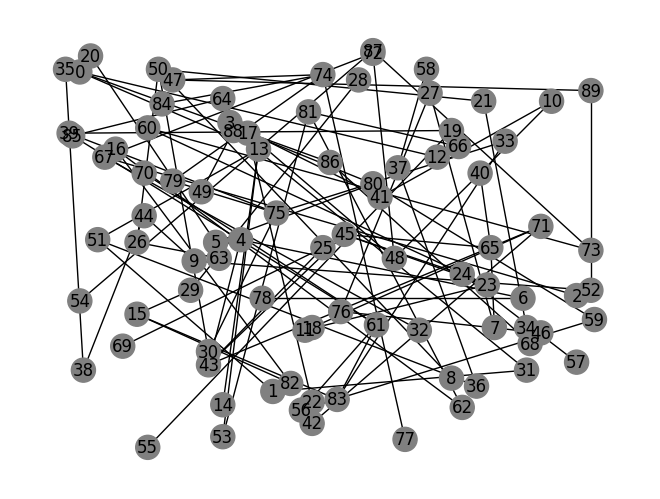

Number of edges:  89
Weight of the edges of the tree:  {(0, 12): 104.9952379872535, (0, 86): 77.82030583337487, (0, 13): 57.8013840664737, (1, 31): 71.449282711585, (1, 51): 75.16648189186454, (2, 67): 141.8731828077456, (3, 41): 50.47771785649585, (4, 6): 82.00609733428362, (4, 43): 47.853944456021594, (5, 20): 78.26237921249263, (5, 80): 49.193495504995376, (6, 78): 73.0, (7, 27): 89.82204629154248, (7, 65): 30.01666203960727, (8, 50): 142.0563268566381, (9, 44): 22.02271554554524, (9, 52): 111.5437134042076, (10, 41): 60.0, (10, 40): 33.60059523282288, (11, 23): 53.75872022286245, (13, 14): 96.51942809610924, (13, 51): 56.4003546088143, (13, 53): 108.46197490364999, (15, 29): 17.4928556845359, (15, 82): 50.24937810560445, (15, 83): 64.4980619863884, (16, 62): 137.17871555019022, (16, 82): 100.72239075796404, (17, 22): 102.59142264341595, (17, 48): 62.369864518050704, (17, 80): 39.824615503479755, (18, 71): 74.43117626371358, (19, 55): 146.23952953972466, (19, 39): 107.00467279516349

In [3]:
import networkx as nx
import utility_functions as uf

# CREATING A TREE NETWORK AND SAVING IT TO A .gml FILE

# T = uf.generate_random_network_tree(N, K, square_dim) N = number of nodes, K = number of flows, square_dim = dimension of the square where the nodes are placed
T = uf.generate_random_network_tree(90, 10, 150)
flows = uf.get_random_flows(T, 3)
uf.draw_tree(T)

nx.write_gml(T, "tree_net/bigtree.gml")

print("Number of edges: ", T.number_of_edges())
print("Weight of the edges of the tree: ", uf.get_weight_of_edges(T))
print("Number of nodes: ", T.number_of_nodes())
print("Number of flows: ", T.graph['K'])
print("Flows with their source and destination:", flows)

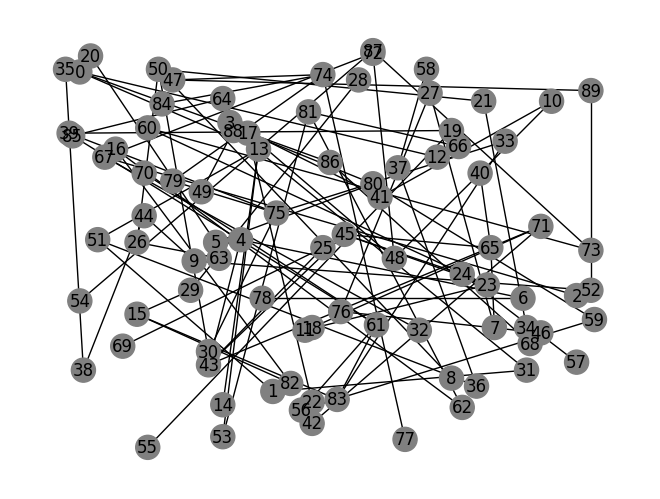

In [3]:
# READING THE TREE NETWORK FROM THE .gml FILE 
path_tree = "tree_net/bigtree.gml"
T = nx.read_gml(path_tree)
uf.draw_tree(T)

### Prima greedy naive

1. Iniziamo con un insieme vuoto di stazioni di ricarica.
2. Per ogni flusso da origine a destinazione, seguiamo il percorso dell'albero. Ogni veicolo (flusso) parte con autonomia L.
3. Mentre percorriamo il percorso, diminuiamo l'autonomia del veicolo della lunghezza dell'arco che si percorre.
4. Se l'autonommia non è sufficiente per percorrere il prossimo arco del percorso, quindi percorrendolo scenderebbe a zero o meno, posizioniamo una colonnina di ricarica sul nodo corrente.
5. Ripetiamo i passaggi 3-4 fino a quando tutti i veicoli hanno raggiunto le loro destinazioni.

Questa euristica cerca di minimizzare il numero di stazioni di ricarica posizionando ogni stazione il più lontano possibile lungo ogni percorso, dato che ogni veicolo parte con la carica completa e ogni stazione di ricarica ricarica completamente la batteria del veicolo.

Chargin stations on nodes: {'62', '82', '53', '83', '60', '39', '72', '40', '59', '85', '48'}
All the paths (a path for each flow):  [['73', '60', '23', '45', '65', '40', '48', '72', '67', '32'], ['64', '85', '61', '83', '15', '82', '16', '62', '81', '53', '13'], ['7', '65', '40', '48', '17', '80', '59', '56', '61', '83', '33', '75', '39', '19']] 

Cost: 11


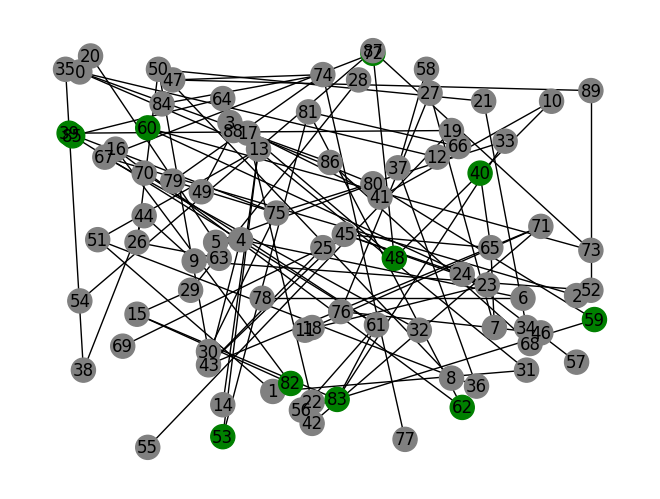

In [4]:
import networkx as nx
import utility_functions as uf

# READING THE TREE NETWORK FROM THE .gml FILE 
T = nx.read_gml("tree_net/bigtree.gml")

K = 3   # the number of flows
L = 150 # the battery capacity of the electric vehicle

flows = uf.get_random_flows(T, K)

def greedy_electric_charging(Tree: nx.Graph, flows: list, L: int):
    charging_stations = set()
    paths = uf.get_all_paths_of_all_flows(Tree, flows)
    for path in paths:
        charge = L
        for i in range(len(path) - 1):
            charge -= Tree.edges[(path[i], path[i+1])]['weight']
            if charge < 0:
                charging_stations.add(path[i])
                Tree.nodes[path[i]]['chrg_station'] = True
                charge = L
    return charging_stations

charging_stations = greedy_electric_charging(T, flows, L)

print("Chargin stations on nodes:", (charging_stations))
print("All the paths (a path for each flow): ", uf.get_all_paths_of_all_flows(T, flows), "\n")

print(f"Cost: {uf.cont_chrg_stations(T)}")
uf.draw_tree(T)


### Algoritmo costruttivo
1. Iniziamo con un insieme di stazioni di ricarica riempito randomicamente.
2. Per ogni flusso da origine a destinazione, seguiamo il percorso dell'albero. Ogni veicolo (flusso) parte con autonomia L.
3. Controlliamo se la soluzione creata inizialmente in maniera randomica è ammissibile, ossia se tutti i veicoli riescono a raggiungere la propria destinazione con le colonnine posizionate.
4. Se quanto detto al punto 3 è vero, allora si è trovata la soluzione ammissibile non ottimale.

Admissible charching stations: ['1', '3', '8', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '25', '26', '29', '31', '32', '33', '35', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '50', '52', '53', '58', '59', '60', '63', '64', '65', '66', '67', '72', '73', '75', '76', '77', '79', '80', '81', '83', '84', '85', '89']
Number of charging stations in the tree: 53
Cost: 53


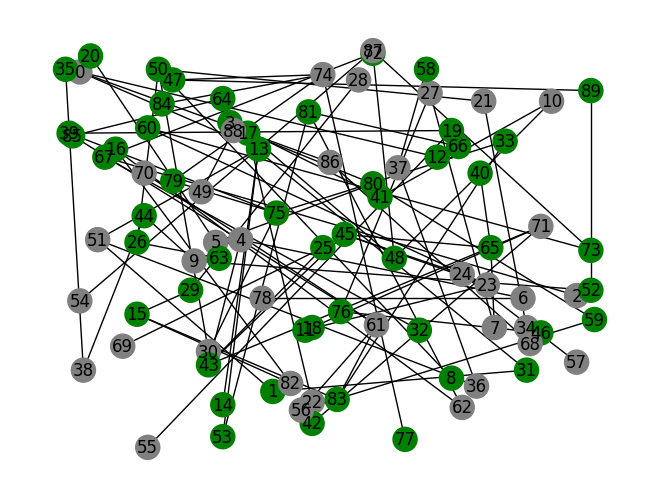

In [5]:
import networkx as nx
import utility_functions as uf
import random

path_tree = "tree_net/bigtree.gml"
# READING THE TREE NETWORK FROM THE .gml FILE 
T = nx.read_gml(path_tree)

K = 3   # the number of flows
L = 150 # the battery capacity of the electric vehicle

flows = uf.get_random_flows(T, K)
paths = uf.get_all_paths_of_all_flows(T, flows)

while True:
    T = nx.read_gml(path_tree)
    charging_stations = uf.set_on_tree_random_chrg_stations(T)
    if uf.is_admissible(T, flows, L):
        print("Admissible charching stations:", charging_stations)
        break
    else:
        pass
print("Number of charging stations in the tree:", uf.cont_chrg_stations(T))
print(f"Cost: {uf.cont_chrg_stations(T)}")

uf.draw_tree(T)

### Algoritmo di programmazione dinamica
GitHub Copilot: Un altro possibile algoritmo per risolvere questo problema potrebbe essere l'utilizzo di un algoritmo di programmazione dinamica. L'idea sarebbe di calcolare il numero minimo di stazioni di ricarica necessarie per ogni coppia di nodi nell'albero.

Ecco un possibile pseudocodice per l'algoritmo:

1. Calcola la matrice delle distanze tra tutti i nodi utilizzando l'algoritmo di Floyd-Warshall.
2. Inizializza una matrice `stations` con le stesse dimensioni della matrice delle distanze, dove `stations[i][j]` rappresenta il numero minimo di stazioni di ricarica necessarie per andare dal nodo `i` al nodo `j`.
3. Per ogni coppia di nodi `(i, j)`, se la distanza `dist[i][j]` è maggiore di `L`, calcola `stations[i][j]` come il minimo di `stations[i][k] + stations[k][j] + 1` per tutti i nodi `k` tali che `dist[i][k]` e `dist[k][j]` siano entrambi minori o uguali a `L`.
4. Alla fine, la somma di `stations[i][j]` per tutte le coppie `(i, j)` nei flussi rappresenta il numero minimo totale di stazioni di ricarica necessarie.

In questo codice, `G` è il grafo generato con networkx, `L` è l'autonomia del veicolo, e `flows` è una lista di coppie di nodi rappresentanti i flussi. La funzione `min_charging_stations` restituisce il numero minimo di colonnine di ricarica necessarie.

In [19]:
import networkx as nx
import utility_functions as uf
import numpy as np

path_tree = "tree_net/bigtree.gml"

# READING THE TREE NETWORK FROM THE .gml FILE 
T = nx.read_gml(path_tree)

K = 3   # the number of flows
L = 70 # the battery capacity of the electric vehicle

flows = uf.get_random_flows(T, K)

def min_charging_stations(G, L, flows):
    n = len(G.nodes)
    dist = nx.floyd_warshall_numpy(G)
    stations = np.zeros((n, n), dtype=int)
    for i in range(n):
        for j in range(n):
            if dist[i, j] > L:
                stations[i, j] = dist[i, j] % L + 1
    return stations

print("Number of charging stations:\n", min_charging_stations(T, L, flows)[0:10])

Number of charging stations:
 [[ 0 50  6 26 62 69  4 11 54 45 56 50 35  0 15 68 57 60 55 62  8  4 23 66
  58 68 48 30 38 16 15 51 44 31 20 31 24 39 58 25 22 46  8 14 67 22 33 21
  52 58 52 45  4 27 42 69 61 34  7 10 38 23 60  1 38 51 55  4 26 65 39 50
  60 30 49 30 46 48  7 61 20 11 18 63 26 64  8 57 33 69]
 [50  0 10 30 65  3  7 14 58 49 60 54 15 62 19  2 61 64 59 66 11  8 26 70
  62  2 51 34 41 20 19  2 47 34 24 34 55 70 61 29 26 50 12 18  1 26 36 25
  56  8 56  6  7 31 45  2 65 38 38 14 42 27 64  5 42 54 59  8  6 69 43 54
  63 34 53 34 50 52 10 65 24 15 22 67 30 67 58 61 54  2]
 [ 6 10  0 68 33 36 45 52  5 66 28 22 41 18 45  8 19 17 27 13 44 25 49 38
  30 40 69  2 48 26 36 11 42 52 41 52 54 69  8 46 64 18 50 56 18 64  4 42
  24 18  3  5 24 50 13 20 15  6 37 67 10 54 16 22 69 22 39  2 32 37 70 22
  17  2 70 51 18 69 48 12 56 65 58 14 47 24 14 29 63 19]
 [26 30 68  0 44 56 56 63 26 16 41 32 61 39 65 29 40 37 37 34 64 46 70 48
  40 50 19 13 68 46 57 32 36  2 61  2  4 19 29 67  5  0 60 

### Ricerca locale
GitHub Copilot: Per risolvere questo problema, possiamo utilizzare un algoritmo di ricerca locale. L'idea è iniziare con una soluzione iniziale (ad esempio, posizionare le colonnine di ricarica in ogni nodo) e poi migliorare iterativamente questa soluzione rimuovendo le colonnine non necessarie.

Ecco un piano passo-passo per l'algoritmo:

1. Carico il tree salvato.
2. Inizializzare una soluzione con colonnine di ricarica in ogni nodo e con il costo iniziale pari al numero di nodi.
3. Per ogni nodo nell'albero, provare a rimuovere la colonnina di ricarica e verificare se tutti i veicoli possono ancora raggiungere le loro destinazioni. Se possono, aggiornare la soluzione e il costo (-1).
4. Ripetere il passaggio 3 fino a quando si fa almeno un miglioramento.

Nota: Questo codice suppone che la lunghezza di ogni arco sia 1. Sostituisci con le lunghezze reali come necessario. Inoltre, l'autonomia L è impostata a 2 come esempio. Modifica secondo le tue esigenze.

Initial solution: {'89', '43', '62', '0', '36', '34', '57', '48', '86', '58', '65', '83', '11', '49', '77', '3', '63', '38', '21', '72', '20', '31', '59', '64', '67', '12', '69', '26', '56', '15', '18', '9', '42', '81', '88', '10', '70', '39', '24', '41', '51', '2', '44', '71', '76', '78', '6', '68', '46', '25', '60', '13', '66', '37', '7', '35', '61', '82', '47', '29', '53', '50', '32', '80', '14', '5', '28', '22', '8', '75', '17', '16', '87', '52', '74', '19', '54', '40', '1', '79', '85', '84', '30', '73', '23', '45', '27', '55', '33', '4'} and cost: 90
Charging stations: {'56', '81', '88', '51', '37', '35', '82', '53', '17', '16', '40', '27'}
Cost: 12


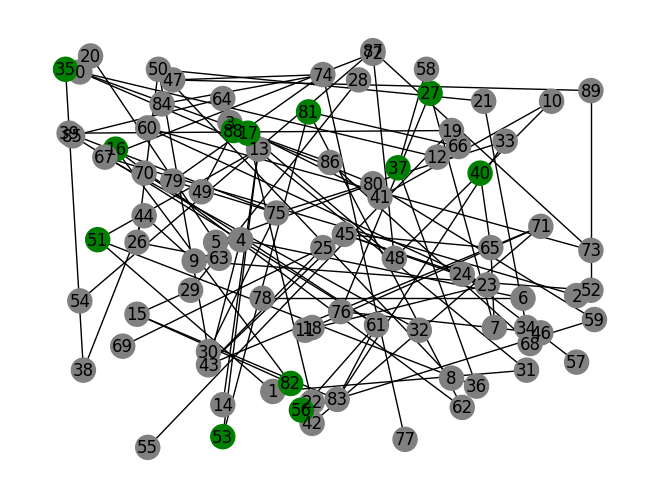

In [9]:
import networkx as nx
import utility_functions as uf

path_tree = "tree_net/bigtree.gml"
# READING THE TREE NETWORK FROM THE .gml FILE 
T = nx.read_gml(path_tree)

K = 3   # the number of flows
L = 150 # the battery capacity of the electric vehicle

flows = uf.get_random_flows(T, K)


def local_search(G, flows, L):
    charging_stations = set(G.nodes)  # initial solution
    uf.set_chrg_stations(G, list(charging_stations))
    cost = len(charging_stations)  # initial cost

    print(f"Initial solution: {charging_stations} and cost: {cost}")

    improved = True
    while improved:
        improved = False
        for node in list(charging_stations):
            charging_stations.remove(node)
            G.nodes[node]['chrg_station'] = False
            if uf.is_admissible(G, flows, L):
                cost -= 1
                improved = True
            else:
                charging_stations.add(node)
                G.nodes[node]['chrg_station'] = True

    return charging_stations, cost




charging_stations, cost = local_search(T, flows, L)
print(f"Charging stations: {charging_stations}")
print(f"Cost: {cost}")
uf.draw_tree(T)


### Altra ricerca locale
Implemento l'algoritmo di prima ma con la feature di cercare il minimo costo possibile e cioè se il costo risulta lo stesso valore per almeno depth volte consecutive

Initial solution: {'25', '28', '76', '1', '67', '31', '52', '85', '3', '22', '89', '24', '69', '84', '26', '27', '79', '10', '77', '39', '50', '37', '33', '62', '21', '64', '60', '19', '23', '40', '29', '58', '57', '86', '7', '41', '88', '18', '82', '83', '46', '2', '49', '78', '81', '16', '9', '30', '17', '5', '70', '73', '42', '14', '55', '35', '75', '13', '34', '0', '8', '71', '44', '36', '53', '15', '61', '48', '45', '51', '65', '87', '38', '4', '74', '12', '68', '63', '72', '6', '54', '59', '56', '11', '66', '80', '47', '43', '32', '20'} and cost: 90
Initial solution: {'25', '28', '76', '1', '67', '31', '52', '85', '3', '22', '89', '24', '69', '84', '26', '27', '79', '10', '77', '39', '50', '37', '33', '62', '21', '64', '60', '19', '23', '40', '29', '58', '57', '86', '7', '41', '88', '18', '82', '83', '46', '2', '49', '78', '81', '16', '9', '30', '17', '5', '70', '73', '42', '14', '55', '35', '75', '13', '34', '0', '8', '71', '44', '36', '53', '15', '61', '48', '45', '51', '65', '

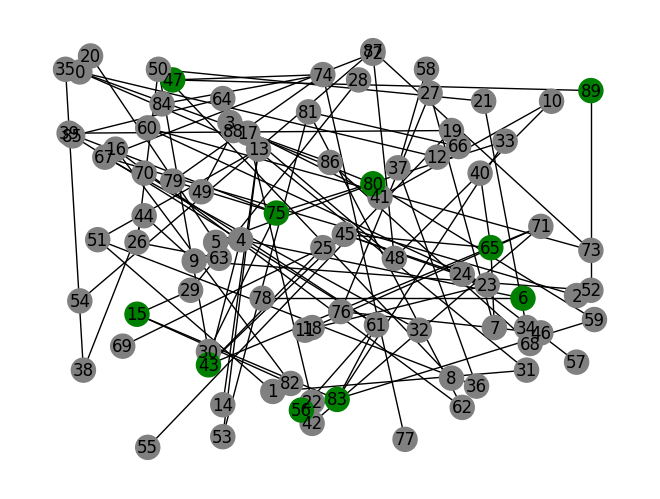

In [7]:
import networkx as nx
import utility_functions as uf

path_tree = "tree_net/bigtree.gml"
# READING THE TREE NETWORK FROM THE .gml FILE 
T = nx.read_gml(path_tree)

K = 3   # the number of flows
L = 150 # the battery capacity of the electric vehicle

flows = uf.get_random_flows(T, K)
depth = 1000 # number of consecutive iterations that cost must be the same value in the local search


def local_search(G, flows, L):
    charging_stations = set(G.nodes)  # initial solution
    uf.set_chrg_stations(G, list(charging_stations))
    cost = len(charging_stations)  # initial cost

    print(f"Initial solution: {charging_stations} and cost: {cost}")

    improved = True
    while improved:
        improved = False
        for node in list(charging_stations):
            charging_stations.remove(node)
            G.nodes[node]['chrg_station'] = False
            if uf.is_admissible(G, flows, L):
                cost -= 1
                improved = True
            else:
                charging_stations.add(node)
                G.nodes[node]['chrg_station'] = True

    return charging_stations, cost

def search(G, flows, L, depth):
    charging_stations, cost = local_search(G, flows, L)
    flag_cost = cost
    cont = 0

    while cont < depth:
        charging_stations, cost = local_search(G, flows, L)
        if cost == flag_cost:
            cont += 1
        else:
            cont = 0
        flag_cost = cost

    return charging_stations, cost

charging_stations, cost = search(T, flows, L, depth)

print(f"Charging stations: {charging_stations}")
print(f"Cost: {cost}")
uf.draw_tree(T)
